In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import scipy
from sklearn.preprocessing import StandardScaler
from scipy import signal
from scipy import fft
from scipy.fft import fft, ifft, fftfreq
import matplotlib
import matplotlib. pyplot as plt
from sklearn.preprocessing import RobustScaler


In [2]:
df = pd.read_csv('/content/attentive dataset 02s - Copy.csv') # change file name acc. to your file as "('/content/"Your_file_name.csv")"
df

,26:50.1,519
0,26:50.1,507
1,26:50.1,502
2,26:50.1,483
3,26:50.1,506
4,26:50.1,492
...,...,...
159994,06:49.7,785
159995,06:49.7,678
159996,06:49.7,780
159997,06:49.7,796


# **Change the Labeling according to your data here **

In [3]:
df.loc[:40000,'label'] = 0 # here we have half data point for relax and other half of attentive state
df.loc[40000:80000,'label'] = 1
df.loc[80000:120000,'label'] = 2 # here we have half data point for relax and other half of attentive state
df.loc[120000:160000,'label'] = 3

In [4]:
df.isnull().sum()

,0
26:50.1,0
519,0
label,0


In [5]:

df.drop(columns=df.columns[0], axis=1, inplace=True)
df

,519,label
0,507,0.0
1,502,0.0
2,483,0.0
3,506,0.0
4,492,0.0
...,...,...
159994,785,3.0
159995,678,3.0
159996,780,3.0
159997,796,3.0


In [6]:
df.columns = ['raw_eeg', 'label']
df

,raw_eeg,label
0,507,0.0
1,502,0.0
2,483,0.0
3,506,0.0
4,492,0.0
...,...,...
159994,785,3.0
159995,678,3.0
159996,780,3.0
159997,796,3.0


In [7]:
data = df['raw_eeg']
labels_old = df['label']



sampling_rate = 512

notch_freq = 50.0  # for the notch filter
lowcut, highcut = 0.5, 30.0  # for the bandpass filter

#  notch filter
nyquist = (0.5 * sampling_rate)
notch_freq_normalized = notch_freq / nyquist
b_notch, a_notch = signal.iirnotch(notch_freq_normalized, Q=0.05, fs=sampling_rate)

#  bandpass filter
lowcut_normalized = lowcut / nyquist
highcut_normalized = highcut / nyquist
b_bandpass, a_bandpass = signal.butter(4, [lowcut_normalized, highcut_normalized], btype='band')

features = []
labels = []
additional_features_list = []

def calculate_psd_features(segment, sampling_rate):
    f, psd_values = scipy.signal.welch(segment, fs=sampling_rate, nperseg=len(segment))

    alpha_indices = np.where((f >= 8) & (f <= 13))
    beta_indices = np.where((f >= 14) & (f <= 30))
    theta_indices = np.where((f >= 4) & (f <= 7))
    delta_indices = np.where((f >= 0.5) & (f <= 3))

    energy_alpha = np.sum(psd_values[alpha_indices])
    energy_beta = np.sum(psd_values[beta_indices])
    energy_theta = np.sum(psd_values[theta_indices])
    energy_delta = np.sum(psd_values[delta_indices])

    # Calculate the alpha-beta ratio feature
    alpha_beta_ratio = energy_alpha / energy_beta

    return {
        'E_alpha': energy_alpha,
        'E_beta': energy_beta,
        'E_theta': energy_theta,
        'E_delta': energy_delta,
        'alpha_beta_ratio': alpha_beta_ratio
    }

def calculate_additional_features(segment, sampling_rate):
    f, psd = scipy.signal.welch(segment, fs=sampling_rate, nperseg=len(segment))

    # Peak frequency
    peak_frequency = f[np.argmax(psd)]

    # Spectral centroid
    spectral_centroid = np.sum(f * psd) / np.sum(psd)

    # Spectral slope
    log_f = np.log(f[1:])
    log_psd = np.log(psd[1:])
    spectral_slope = np.polyfit(log_f, log_psd, 1)[0]

    return {
        'peak_frequency': peak_frequency,
        'spectral_centroid': spectral_centroid,
        'spectral_slope': spectral_slope
    }


for i in range(0, len(data) - 512, 256):
    segment = data.loc[i:i+512]
    segment = pd.to_numeric(segment, errors='coerce')

    #  notch filter
    segment = signal.filtfilt(b_notch, a_notch, segment)

    #  bandpass filter
    segment = signal.filtfilt(b_bandpass, a_bandpass, segment)


    segment_features = calculate_psd_features(segment,512)
    additional_features = calculate_additional_features(segment, 512)

    segment_features = {**segment_features, **additional_features}

    features.append(segment_features)
    labels.append(labels_old[i])

X = np.array(features)
y = np.array(labels)

In [8]:
#features
segment_features

{'E_alpha': 8.768172935724877,
 'E_beta': 50.78264896539114,
 'E_theta': 6.201978579936563,
 'E_delta': 2.5951045195096842,
 'alpha_beta_ratio': 0.1726608027419064,
 'peak_frequency': 15.968810916179336,
 'spectral_centroid': 15.88220569284006,
 'spectral_slope': -10.111986467222136}

In [9]:
columns = ['E_alpha', 'E_beta', 'E_theta', 'E_delta', 'alpha_beta_ratio','peak_frequency','spectral_centroid','spectral_slope']

# Create a DataFrame
df = pd.DataFrame(features, columns=columns)

df['label'] = y


In [10]:
df.describe()

,E_alpha,E_beta,E_theta,E_delta,alpha_beta_ratio,peak_frequency,spectral_centroid,spectral_slope,label
count,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000
mean,8.826992,26.035070,3.360518,17.462140,0.391292,6.484926,12.494754,-10.750196,1.492777
std,8.789737,21.978750,3.966043,23.737435,0.298327,8.362149,3.453279,0.464050,1.118190
min,0.335261,3.880288,0.100366,0.120896,0.014671,0.000000,3.490535,-13.058867,0.000000
25%,3.356193,11.130909,1.046485,3.783032,0.196005,0.998051,10.001617,-11.006133,0.000000
50%,5.850757,17.813897,2.001234,9.007126,0.310454,0.998051,12.839840,-10.705366,1.000000
75%,10.649203,30.530237,3.965997,22.288495,0.485042,13.473684,15.308600,-10.418100,2.000000
max,63.977757,144.413950,40.652637,183.388871,2.511795,29.941520,19.627692,-9.870829,3.000000


In [11]:
#df.to_csv('ready.csv')

In [12]:
scaler = StandardScaler()
#scaler = RobustScaler()
X_scaled = scaler.fit_transform(df.drop('label', axis=1))
df_scaled = pd.DataFrame(X_scaled, columns=columns)

# Add labels to the DataFrame
df_scaled['label'] = df['label']

In [13]:
#df_scaled
X_scaled

array([[-0.04765986, -0.57150614, -0.67327367, ..., -0.65668342,
        -1.51212182, -1.27801523],
       [-0.48685211, -0.30842092, -0.07943629, ..., -0.65668342,
         0.51601438, -0.15071354],
       [-0.8586394 , -0.54407273, -0.21258825, ..., -0.65668342,
        -0.75028152,  1.42487053],
       ...,
       [ 2.26419255,  1.06042269, -0.25357676, ..., -0.65668342,
         0.77516241,  1.5704504 ],
       [ 0.68944476,  1.27046706,  1.78753915, ..., -0.65668342,
        -0.66729271,  0.49927559],
       [-0.00669715,  1.12688228,  0.717023  , ...,  1.13505573,
         0.98172602,  1.37641031]])

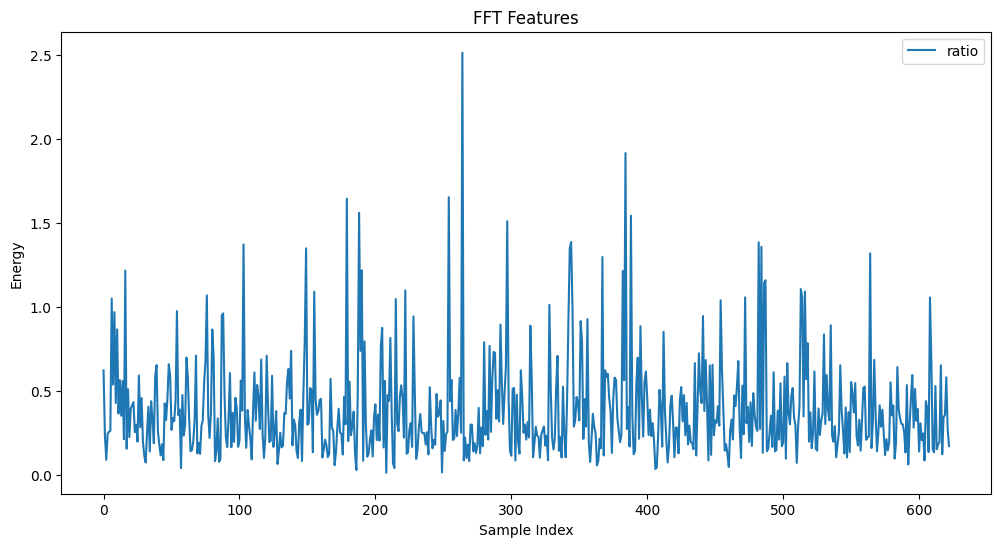

In [14]:
import matplotlib.pyplot as plt



# Plot FFT features
plt.figure(figsize=(12, 6))
#plt.plot(df.index, df['E_alpha'], label='Alpha Energy')
#plt.plot(df.index, df['E_beta'], label='Beta Energy')
###plt.plot(df.index, df['E_theta'], label='theta Energy')
#plt.plot(df.index, df['E_delta'], label='delta Energy')

plt.plot(df.index, df['alpha_beta_ratio'], label='ratio')

plt.xlabel('Sample Index')
plt.ylabel('Energy')
plt.title('FFT Features')
plt.legend()
plt.show()




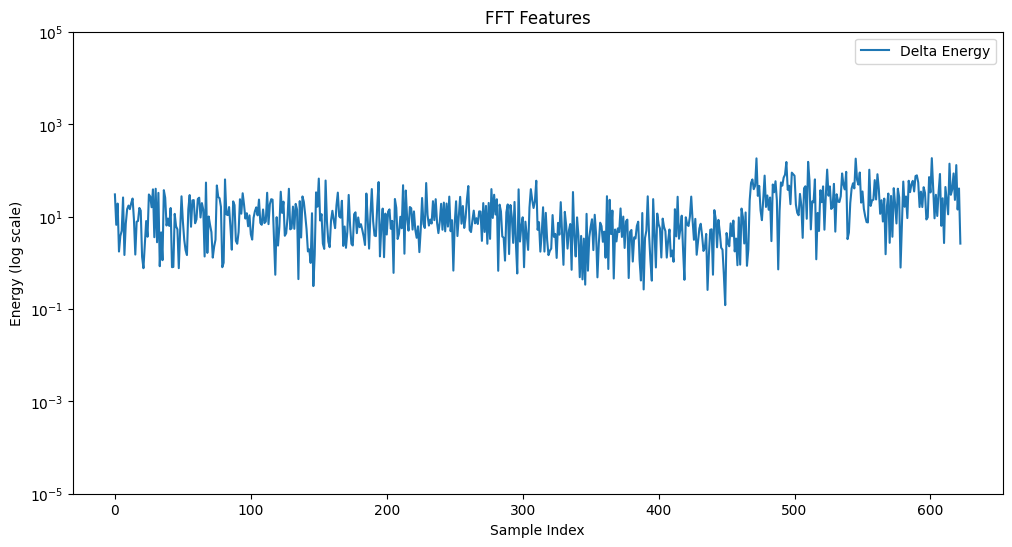

In [15]:
import matplotlib.pyplot as plt

# Plot FFT features
plt.figure(figsize=(12, 6))
#plt.plot(df.index, df['E_alpha'], label='Alpha Energy')
#plt.plot(df.index, df['E_beta'], label='Beta Energy')
#plt.plot(df.index, df['E_theta'], label='Theta Energy')
plt.plot(df.index, df['E_delta'], label='Delta Energy')
#plt.plot(df.index, df['alpha_beta_ratio'], label='Alpha/Beta Ratio')

plt.yscale('log')

threshold = 1e5
plt.ylim([1e-5, threshold])

plt.xlabel('Sample Index')
plt.ylabel('Energy (log scale)')
plt.title('FFT Features')
plt.legend()
plt.show()


In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled.drop('label', axis=1), df_scaled['label'], test_size=0.2, random_state=42)

#clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf = SVC(probability=True, random_state=42)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy}")

Classification Accuracy: 0.616


In [17]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

X = df_scaled.drop('label', axis=1)
y = df_scaled['label']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

svc = SVC(probability=True)

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

model = grid_search.best_estimator_
y_pred = model.predict(X_test)
test_accuracy = model.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(test_accuracy))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.73
Test set accuracy: 0.63


In [18]:
X_test

,E_alpha,E_beta,E_theta,E_delta,alpha_beta_ratio,peak_frequency,spectral_centroid,spectral_slope
249,-0.961164,-0.128338,-0.439826,-0.707747,-1.256986,1.254505,1.725118,-0.496197
558,-0.014113,0.034855,0.016449,0.238390,-0.223283,-0.656683,-0.713219,0.986790
174,-0.606061,-0.554238,-0.711383,-0.628612,-0.464726,0.896157,1.283811,-0.217067
280,0.210211,-0.570397,-0.433465,-0.270025,1.337918,-0.656683,-0.041817,0.122336
110,-0.583407,-0.742165,-0.581579,-0.431809,-0.036739,-0.656683,-0.296691,1.163756
...,...,...,...,...,...,...,...,...
6,0.195192,-0.728675,-0.068456,0.353689,2.212159,-0.656683,-1.582113,0.714359
104,0.066426,0.081835,0.226756,-0.070346,-0.178407,-0.656683,-0.175909,-0.420590
114,0.807052,0.368937,0.790915,0.044649,0.251320,-0.656683,-0.123044,0.457147
355,-0.782750,-0.877030,-0.414075,-0.715880,-0.345881,0.896157,1.660676,0.639162


In [19]:
import pickle

model_filename = 'model.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(model, file)


In [20]:
import pickle

scaler_filename = 'scaler.pkl'

with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)


In [21]:
probabilities = model.predict_proba(X_test)[:,1]
print(f"Class Probabilities: {probabilities}")

Class Probabilities: [3.07341889e-01 4.35914917e-01 2.04015582e-01 5.78078972e-01
 1.32799459e-01 3.52795731e-01 9.09470301e-02 5.26783758e-01
 1.63012161e-02 3.47159545e-01 1.65347432e-02 2.37617597e-01
 5.96903126e-01 4.02202323e-01 2.97189511e-01 8.70022972e-08
 6.40246298e-08 5.11736019e-01 5.19613163e-01 5.11604993e-01
 4.32719239e-02 4.00354670e-01 4.40889585e-01 6.01745800e-01
 8.42051298e-07 4.17752843e-01 1.87996784e-02 6.00072859e-01
 4.91555342e-01 7.34919482e-02 5.78833987e-02 1.13183920e-02
 2.83318759e-06 3.69116694e-01 4.34185606e-01 3.61858255e-01
 2.47548878e-03 2.60169095e-01 5.22376313e-01 4.80495064e-01
 3.10394916e-01 2.59194781e-01 4.84392072e-01 1.11361282e-01
 3.07140028e-01 2.68081165e-02 2.34710859e-01 3.45065945e-01
 2.22581908e-01 4.11793098e-01 3.90069358e-01 9.57151070e-02
 3.04990345e-06 2.10433988e-01 2.54352150e-01 4.99448168e-02
 2.95137485e-01 2.32633034e-06 3.69890892e-01 4.60072275e-01
 1.76958090e-06 1.40724579e-03 5.16667767e-02 2.61338285e-04
 9.

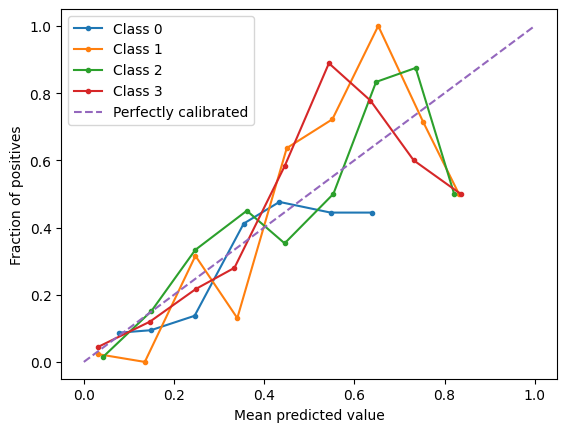

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.datasets import make_classification

# Generate a sample dataset
X, y = make_classification(n_samples=1000, n_classes=4, n_informative=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model using OneVsRestClassifier
model = OneVsRestClassifier(LogisticRegression())
model.fit(X_train, y_train)

# Predict probabilities
probabilities = model.predict_proba(X_test)

# Plot calibration curve for each class
for i in range(probabilities.shape[1]):
    fop, mpv = calibration_curve(y_test == i, probabilities[:, i], n_bins=10)
    plt.plot(mpv, fop, marker='.', label=f'Class {i}')

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()


In [23]:
from sklearn.calibration import CalibratedClassifierCV

calibrator = CalibratedClassifierCV(model, cv=3)
calibrator.fit(X_train,y_train)
yhat = calibrator.predict(X_test)

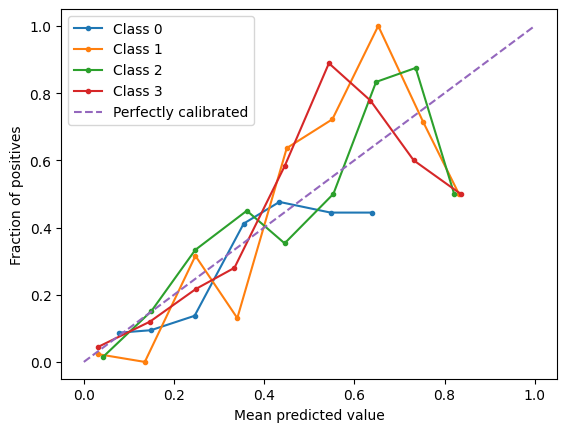

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.datasets import make_classification

# Generate a sample dataset
X, y = make_classification(n_samples=1000, n_classes=4, n_informative=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model using OneVsRestClassifier
model = OneVsRestClassifier(LogisticRegression())
model.fit(X_train, y_train)

# Predict probabilities
probabilities = model.predict_proba(X_test)

# Plot calibration curve for each class
for i in range(probabilities.shape[1]):
    fop, mpv = calibration_curve(y_test == i, probabilities[:, i], n_bins=10)
    plt.plot(mpv, fop, marker='.', label=f'Class {i}')

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()


In [25]:
accuracy = accuracy_score(y_test, yhat)
print(f"Classification Accuracy: {accuracy}")

Classification Accuracy: 0.62


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# Generate a sample dataset
X, y = make_classification(n_samples=1000, n_features=8, n_informative=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Accuracy: 0.8150
Precision: 0.8269
Recall: 0.8190
F1 Score: 0.8230
Confusion Matrix:
[[77 18]
 [19 86]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81        95
           1       0.83      0.82      0.82       105

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.82      0.81      0.82       200

